<a href="https://colab.research.google.com/github/betr0dalf/TIMO/blob/main/TIMO_NovikovDV_prac7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Технологии и инструментарий машинного обучения
# Практическая работа № 7
# Выполнил студент группы ИНБО-05-22
# Новиков Денис Владиславович

## Импорт необходимых библиотек

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Загрузка и предобработка данных

In [ ]:
# Загрузка данных
data = pd.read_csv('diabetes_dataset.csv')

# Удаление повторяющихся строк
data = data.drop_duplicates()

print('Размерность данных:', data.shape, end='\n\n')
data.head()

Размерность данных: (768, 9)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Определение целевого столбца
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Применяем StandardScaler только к признакам
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## № 1. Линейная регрессия и значимость на основе значений признаков

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

coefficients = model.coef_

r_squared = model.score(X_test, y_test)

print("R² модели:", r_squared)

R² модели: 0.7857142857142857


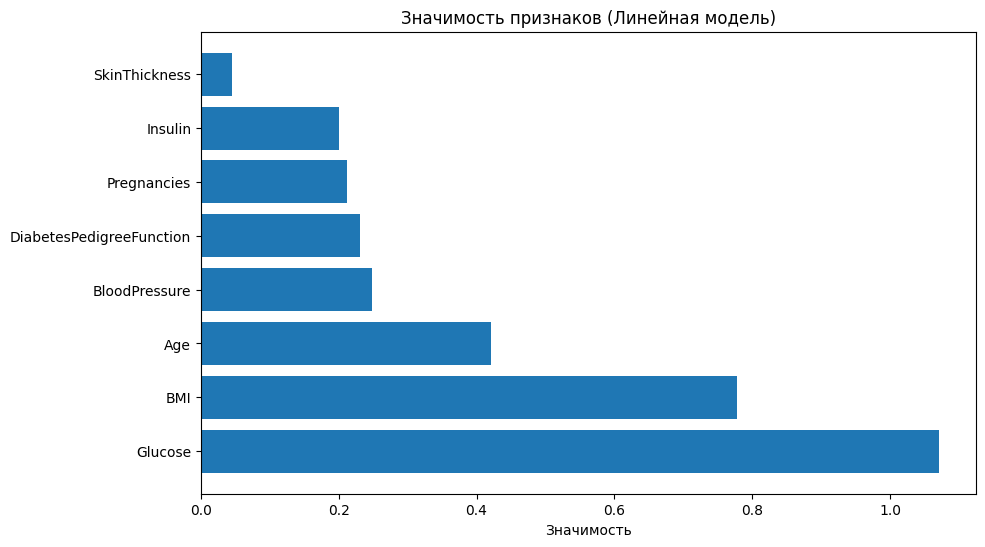

In [ ]:
coefficients = model.coef_[0]  # Извлекаем коэффициенты первой строки
feature_names = X.columns      # Названия признаков

# Вычисление значимости
importance = np.abs(coefficients)
sorted_indices = np.argsort(importance)[::-1]  # Индексы в порядке убывания значимости

# Сортировка признаков по значимости
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importance = importance[sorted_indices]

# Построение графика значимости признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance)
plt.xlabel('Значимость')
plt.title('Значимость признаков (Линейная модель)')
plt.show()

## № 2. Жадный отбор признаков

In [ ]:
# Создание селектора для выбора 3 лучших признаков
selector = SequentialFeatureSelector(LogisticRegression(max_iter=10000), n_features_to_select=3)
selector.fit(X_train, y_train)

# Извлечение имен выбранных признаков
selected_features = X.columns[selector.get_support()]
print("Выбранные признаки:", selected_features.tolist())

Выбранные признаки: ['Pregnancies', 'Glucose', 'BMI']


## № 3. Отбор признаков с помощью L1

In [ ]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

print("Коэффициенты Лассо:", lasso_model.coef_)
print(f'Количество ненулевых коэффициентов: {sum(lasso_model.coef_ != 0)}')

Коэффициенты Лассо: [0.         0.1115119  0.         0.         0.         0.02291842
 0.         0.00329461]
Количество ненулевых коэффициентов: 3


## № 4. Ансамбли

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Точность (Случайный лес):", accuracy_score(y_test, y_pred_rf))

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("Точность (Градиентный бустинг):", accuracy_score(y_test, y_pred_gb))

Точность (Случайный лес): 0.7597402597402597
Точность (Градиентный бустинг): 0.7337662337662337


### № 4.1 Встроенная важность признаков

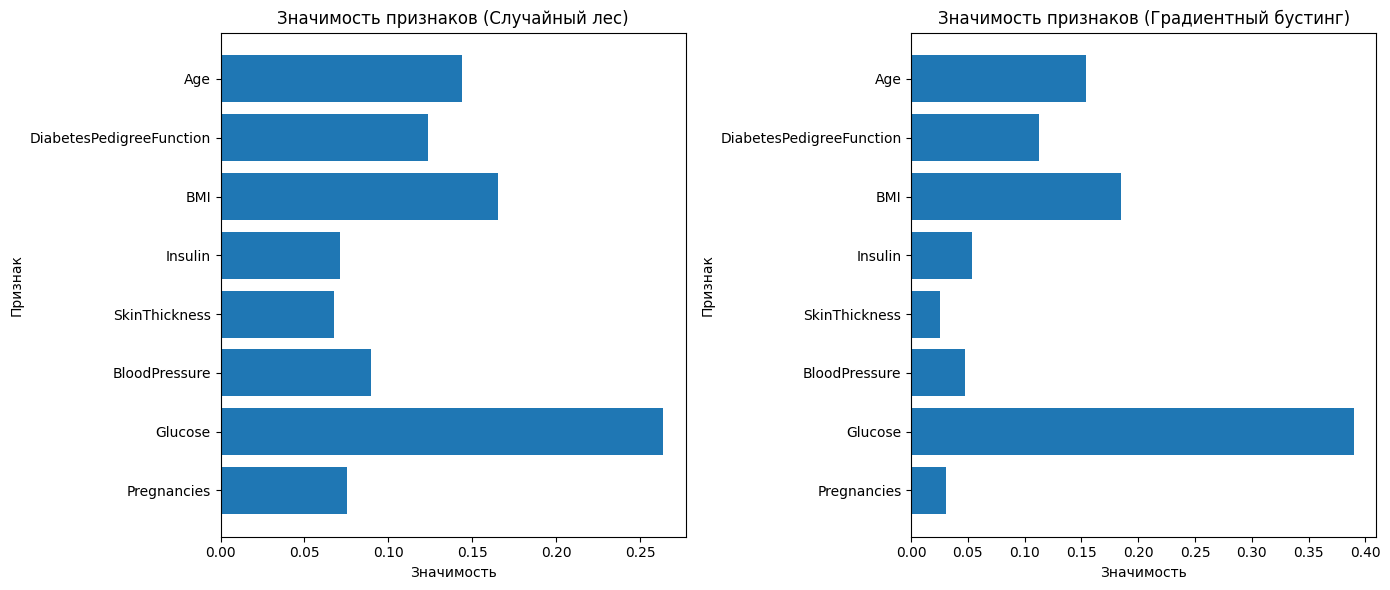

In [ ]:
rf_importance = rf_model.feature_importances_

gb_importance = gb_model.feature_importances_

feature_names = data.drop("Outcome", axis=1).columns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(feature_names, rf_importance)
ax[0].set_title("Значимость признаков (Случайный лес)")
ax[0].set_xlabel("Значимость")
ax[0].set_ylabel("Признак")

ax[1].barh(feature_names, gb_importance)
ax[1].set_title("Значимость признаков (Градиентный бустинг)")
ax[1].set_xlabel("Значимость")
ax[1].set_ylabel("Признак")


plt.tight_layout()

### № 4.2 Оценка важности с помощью SHAP

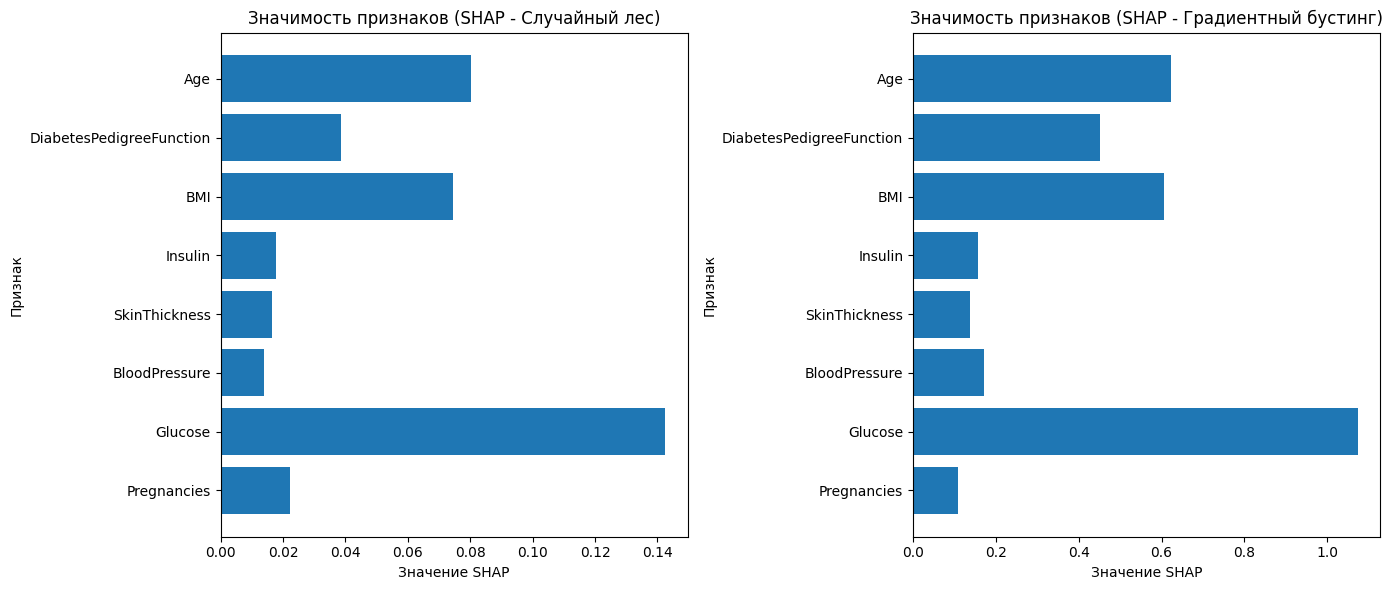

In [ ]:
explainer_rf = shap.TreeExplainer(rf_model)
explainer_gb = shap.TreeExplainer(gb_model)

shap_values_rf = explainer_rf.shap_values(X_test)
shap_values_gb = explainer_gb.shap_values(X_test)

mean_abs_shap_values_rf = np.abs(shap_values_rf[:,:,0]).mean(axis=0)
mean_abs_shap_values_gb = np.abs(shap_values_gb).mean(axis=0)

feature_names = data.drop("Outcome", axis=1).columns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(feature_names, mean_abs_shap_values_rf)
ax[0].set_title("Значимость признаков (SHAP - Случайный лес)")
ax[0].set_xlabel("Значение SHAP")
ax[0].set_ylabel("Признак")

ax[1].barh(feature_names, mean_abs_shap_values_gb)
ax[1].set_title("Значимость признаков (SHAP - Градиентный бустинг)")
ax[1].set_xlabel("Значение SHAP")
ax[1].set_ylabel("Признак")

plt.tight_layout()

## № 5. Сравнение качества на всех признаках и $n$ самых важных


In [ ]:
rf_importances = rf_model.feature_importances_

top_3_rf_indices = np.argsort(rf_importances)[-3:]

X_train_top3_rf = X_train[:, top_3_rf_indices]
X_test_top3_rf = X_test[:, top_3_rf_indices]

rf_top3 = RandomForestClassifier(n_estimators=100)
rf_top3.fit(X_train_top3_rf, y_train)

y_pred_rf_top3 = rf_top3.predict(X_test_top3_rf)
accuracy_rf_top3 = accuracy_score(y_test, y_pred_rf_top3)

gb_importances = gb_model.feature_importances_

top_3_gb_indices = np.argsort(gb_importances)[-3:]

X_train_top3_gb = X_train[:, top_3_gb_indices]
X_test_top3_gb = X_test[:, top_3_gb_indices]

gb_top3 = GradientBoostingClassifier(n_estimators=100)
gb_top3.fit(X_train_top3_gb, y_train)

y_pred_gb_top3 = gb_top3.predict(X_test_top3_gb)
accuracy_gb_top3 = accuracy_score(y_test, y_pred_gb_top3)

y_pred_rf_all = rf_model.predict(X_test)
accuracy_rf_all = accuracy_score(y_test, y_pred_rf_all)

y_pred_gb_all = gb_model.predict(X_test)
accuracy_gb_all = accuracy_score(y_test, y_pred_gb_all)

print(f"Точность случайного леса (все признаки): {accuracy_rf_all:.4f}")
print(f"Точность случайного леса (топ 3 признака): {accuracy_rf_top3:.4f}")
print(f"Точность градиентного бустинга (все признаки): {accuracy_gb_all:.4f}")
print(f"Точность градиентного бустинга (топ 3 признака): {accuracy_gb_top3:.4f}")

Точность случайного леса (все признаки): 0.7597
Точность случайного леса (топ 3 признака): 0.7403
Точность градиентного бустинга (все признаки): 0.7338
Точность градиентного бустинга (топ 3 признака): 0.7208


## № 6. Обучение на признаках, полученных с помощью PCA, визуализация T-SNE

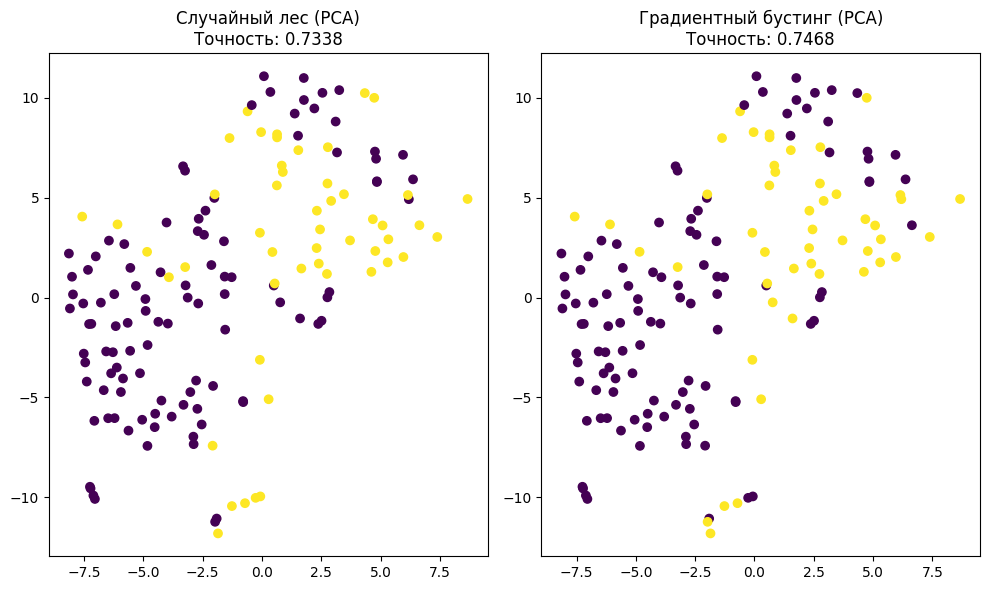

In [ ]:
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_pca = RandomForestClassifier(n_estimators=100)
rf_pca.fit(X_train_pca, y_train)

gb_pca = GradientBoostingClassifier(n_estimators=100)
gb_pca.fit(X_train_pca, y_train)

y_pred_rf_pca = rf_pca.predict(X_test_pca)
accuracy_rf_pca = accuracy_score(y_test, y_pred_rf_pca)

y_pred_gb_pca = gb_pca.predict(X_test_pca)
accuracy_gb_pca = accuracy_score(y_test, y_pred_gb_pca)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_test)

plt.figure(figsize=(10, 6))

plt.subplot(121)
scatter_rf = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_rf_pca)
plt.title(f"Случайный лес (PCA)\nТочность: {accuracy_rf_pca:.4f}")

plt.subplot(122)
scatter_gb = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_gb_pca)
plt.title(f"Градиентный бустинг (PCA)\nТочность: {accuracy_gb_pca:.4f}")

plt.tight_layout()